## In this notebook, amplicon data will be imported as raw read counts and each ASV occurrence will be modeled as a probability distribution. Samples will then be clustered based on their overall community composition.

### Import all the dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import subprocess

### Move to working directory

In [24]:
os.chdir('/Users/nastassia.patin/GitHub/NOAA-NCAR-Hackathon')

### 01. This section imports the amplicon data as raw counts and calls an R script to model the ASV occurrence as a probability distribution. 

#### Import example amplicon data sheet and take a look

In [3]:
file = 'Lasker2018_table_counts.tsv'
asvs = pd.read_csv(file, index_col=0, sep='\t')
asvs

,Flyer18Fc03_10_1,Flyer18Fc03_3_1,Flyer18Fc09_10_1,Flyer18Fc09_4_1,Flyer18Fc13_10_1,Flyer18Fc13_3_1,Lasker18Sc122_17,Lasker18Sc122_19,Lasker18Sc122_3,Lasker18Sc122_5,...,Lasker18Sc153_3,Lasker18Sc153_5,Lasker18Sc154_17,Lasker18Sc154_19,Lasker18Sc154_3,Lasker18Sc154_5,Lasker18Sc158_17,Lasker18Sc158_19,Lasker18Sc158_3,Lasker18Sc158_5
ASV ID,,,,,,,,,,,,,,,,,,,,,
a404bf4d32831f2133794e5fe5d0a73e,117,6319,4111,80,3916,151,514,452,5608,2089,...,3377,5228,232,283,5670,5001,78,49,5965,6185
f35c0a576bb1ab3577191cb12352c249,419,58,45,322,22,155,176,149,234,62,...,615,811,5053,7187,166,112,7859,7144,480,992
588253f8c914de60cbb9577946854a39,1975,1843,3545,2913,2398,5836,16700,14422,2638,1022,...,1156,1871,517,798,722,504,229,156,2527,2998
d883e3b29658c861ac524bbfc2cef34d,124,39,31,80,0,0,0,0,63,0,...,322,281,10969,13535,142,144,6950,6198,265,728
3468430277ce2317dec6f413dcfaa03e,1440,31,115,1258,29,434,480,367,97,41,...,266,345,2336,3027,81,49,2969,2279,325,507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5dc6c2efdb748cb3508b4e8592239b83,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6f477eb9c90036177a1a870f0d4d5cc8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
fd5567754d768cc191c36f6aaa99c51d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Call the R script to model the ASV count distributions

In [50]:
# Define command and arguments
path_to_rscript = '/Users/nastassia.patin/GitHub/NOAA-NCAR-Hackathon/ranRelPct_example.R'
number_of_samples = 87

In [49]:
def call_Rscript_for_amplicon_modeling(path, sample_num):
    # Use subprocess.Popen to open executable Rscript and extract stdout from 'print' command in R
    with subprocess.Popen(['Rscript', '--vanilla', path], 
                          stdout=subprocess.PIPE) as result:
        asvs_freq = result.stdout.read()
    
    # The R output gets imported as "bytes"; need to convert to string
    y = asvs_freq.decode("utf-8")
    y = y.replace(",", "").split()

    # remove the column and row headers
    z = [ x for x in y if "[" not in x ]

    # Convert to numpy array
    array = np.asarray(z)
    # Reshape to original dimensions; number of samples (columns) is second field, 
    # unknown number of ASVs can be supplied with '-1'
    mat = np.reshape(array, (-1, sample_num))

    # Covert to data frame with sample names as columns
    names = np.arange(1, sample_num+1, 1)
    df = pd.DataFrame(mat, columns=names)
    return(df)

In [51]:
asvs_modeled = call_Rscript_for_amplicon_modeling(path_to_rscript, number_of_samples)

In [52]:
asvs_modeled

,1,2,3,4,5,6,7,8,9,10,...,78,79,80,81,82,83,84,85,86,87
0,1.365285e-03,5.338151e-02,4.215042e-02,1.241695e-03,4.185887e-02,4.900488e-03,5.392736e-04,6.005729e-04,3.764205e-03,3.196646e-04,...,6.968922e-03,5.517463e-08,7.229999e-03,3.593783e-02,6.604294e-04,6.809703e-04,3.044479e-02,8.963759e-04,2.704388e-02,1.267389e-04
1,9.717466e-04,2.547122e-02,3.883703e-04,1.289863e-02,6.918792e-06,6.311991e-06,1.403138e-02,2.640637e-06,2.731384e-03,6.702664e-03,...,5.408048e-04,1.542970e-06,8.958469e-06,8.730091e-06,4.081581e-06,8.338660e-07,1.417173e-02,5.329663e-04,1.800726e-03,9.841734e-03
2,1.030880e-03,2.670632e-05,8.706372e-03,5.589074e-03,5.099777e-06,6.514625e-03,1.906610e-07,1.274330e-02,7.647441e-03,2.933713e-05,...,1.480273e-03,1.626926e-03,2.839135e-03,1.258022e-03,6.678979e-04,2.337402e-06,3.629462e-06,2.981624e-05,2.334594e-06,2.541195e-06
3,5.906222e-03,7.566276e-03,1.046238e-05,7.397018e-03,3.529543e-03,1.580044e-05,2.329106e-06,1.244674e-03,5.908470e-06,3.153111e-05,...,3.220812e-05,2.559664e-03,5.898886e-03,7.213262e-06,1.155160e-04,6.384967e-03,1.223072e-04,3.728097e-06,7.219783e-03,7.104754e-03
4,4.101539e-06,9.953164e-03,5.475923e-04,2.802755e-03,1.169535e-03,9.369369e-04,1.269891e-03,2.194503e-03,3.258409e-04,9.891836e-04,...,6.238373e-06,3.492351e-03,2.169717e-03,9.237303e-06,2.395375e-03,1.937062e-03,2.622731e-07,1.099102e-05,6.812034e-04,2.513308e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28737,7.271424e-07,1.004472e-05,1.747990e-05,7.239045e-06,1.355027e-05,3.965789e-06,8.255255e-06,8.474237e-06,8.020311e-06,1.080916e-07,...,4.699515e-08,7.411511e-06,1.452641e-05,1.559160e-06,3.247564e-06,6.518681e-06,1.715575e-05,6.883416e-06,3.439815e-06,4.298013e-06
28738,1.735330e-05,6.484995e-06,1.250426e-05,2.156107e-05,1.715673e-05,2.102426e-05,4.197074e-05,1.854121e-05,8.173222e-06,4.439545e-06,...,9.512304e-07,3.200857e-06,6.553044e-07,1.144262e-05,1.657529e-05,7.651687e-05,1.051146e-05,8.802120e-06,2.866683e-06,4.696232e-06
28739,9.097348e-06,4.068777e-07,1.051104e-05,1.697428e-06,3.869500e-05,6.810935e-06,3.649790e-06,1.536164e-05,1.536402e-06,1.705714e-05,...,2.186612e-05,3.030526e-06,2.746073e-05,4.039630e-06,4.686970e-05,1.340396e-05,9.362278e-06,2.783461e-05,1.195012e-05,7.934752e-06
28740,2.984760e-06,1.974482e-05,3.951655e-06,3.705690e-06,2.751728e-06,5.705190e-05,3.025262e-06,1.961301e-05,6.622725e-07,8.678235e-06,...,8.704568e-06,1.222334e-06,1.028802e-05,2.274663e-05,2.085841e-05,1.021881e-05,1.006378e-05,2.763166e-06,1.905220e-05,1.139647e-06


## 02. Use the transformed table generated in [01] to cluster samples based on community composition.

In [218]:
clusters = subprocess.call("Rscript '/Users/nastassia.patin/GitHub/NOAA-NCAR-Hackathon/cluster_example.R", 
                         shell=True)
clusters

,Sample,Day,GE,mgn_bps,MAG,Raw_TAD,MAG_size,Normalized_TAD,MAG_proportion
0,15_8,22,981.13545,88410340775,13_1_001,9.123320,7953998.182,0.009299,0.000821
1,15_8,22,981.13545,88410340775,14_1_002,0.557976,2982715.048,0.000569,0.000019
2,15_8,22,981.13545,88410340775,14_1_003,0.000000,2346629.669,0.000000,0.000000
3,15_8,22,981.13545,88410340775,14_1_005,0.000000,2952562.304,0.000000,0.000000
4,15_8,22,981.13545,88410340775,14_4_005,1.490583,2833498.943,0.001519,0.000048


## 03. This section could provide some visualization of the clusters? The below are just placeholders showing examples of PCAs and k-means clusters in Python.

Text(0, 0.5, 'PCA 2')

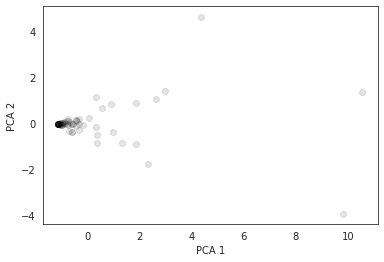

In [230]:
PCA_components = pd.DataFrame(principalComponents)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## 04b. K-means clustering

### Determine levels of inertia as a function of cluster number

In [231]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

In [232]:
inertias

[350.34640542612715,
 133.2579511492458,
 67.12397429798082,
 42.517500459000814,
 28.335125723037308,
 17.426266962199804,
 10.601480151337611,
 7.413672741415341,
 4.511421154337272]

### Determine how many clusters are most informative. Once the line starts to level out, more clusters become less useful.

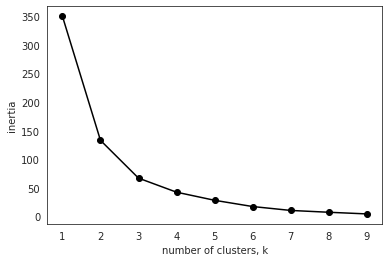

In [233]:
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Initialize k-means using ideal number of clusters. I decided to use 6 clusters in this case.

In [234]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(principalDf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Determine the centroids of each cluster

In [235]:
labels = kmeans.predict(principalDf)
centroids = kmeans.cluster_centers_
centroids

array([[-0.81853918, -0.04825301],
       [10.55821541,  1.3548933 ],
       [ 4.35423608,  4.63376339],
       [ 1.55559309,  0.99094764],
       [ 9.80070917, -3.94923207],
       [ 1.09982558, -0.78917244]])

### Plot the clusters with the centroids marked by (*)

Text(0.5, 1.0, '15 MAG K-means')

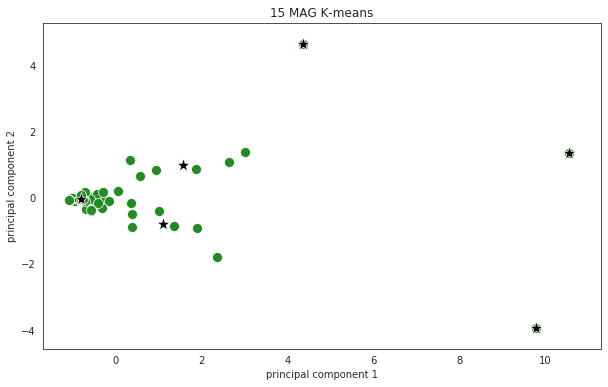

In [236]:
plt.figure(figsize=(10, 6))
sns.set_style("white")
sns.scatterplot(finalDf.iloc[:, 0], finalDf.iloc[:, 1], s=100, color="forestgreen")
sns.scatterplot(centroids[ :, 0], centroids[ :, 1], marker='*', s=200, color="black")
plt.title('15 MAG K-means')

## Looks like there aren't really distinct clusters of MAGs based on similar time series values. However, there are some individual MAGs that are differentiated from most of the others. It might be worth scaling or standardizing the data in a different way. For now, we can still extract the centroid points as they might be useful for identifying those three outlier MAGs. 

### Extract points of each cluster

In [237]:
#Labels of each point
kmeans.labels_

array([5, 0, 0, 0, 0, 0, 3, 0, 5, 0, 3, 3, 3, 4, 5, 5, 1, 2, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

### Get the indices of the points for each corresponding cluster

In [238]:
points = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
points

{0: array([ 1,  2,  3,  4,  5,  7,  9, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 49, 50, 51, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 1: array([16]),
 2: array([17]),
 3: array([ 6, 10, 11, 12, 18, 48]),
 4: array([13]),
 5: array([ 0,  8, 14, 15, 54, 55, 56])}

### Save cluster lists

In [115]:
# pd.DataFrame.from_dict(data=points, orient='index').to_csv('15-kmeans-cluster-6.csv', header=False)

### If you got this far, thank you! Please let me know if you have any questions, and keep your eyes one for a study using this script to analyze human gut microbiomes infected with Norovirus.